# LSAP Data Inspection & Retrieval
---
This notebook contains code for retrieving the Wikihow Intents data used in our NLP project. 


## Install Libraries & Set Seed

In [9]:
import random, torch
import numpy as np
import pandas as pd

def set_seed( seed ):
    random.seed( seed )
    np.random.seed( seed )
    torch.manual_seed( seed )
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all( seed )

#Set seed for consistency
set_seed(42)

#Set to True to combine all data or False for "train.csv", "val.csv", "test.csv"
COMBINE = True

#Set train, val, and test split sizes
TRAIN_SPLIT = 0.6
VAL_SPLIT   = 0.2
TEST_SPLIT  = 0.2

## Preprocess pre-training dataset

Our pre-training dataset is a combination of the [Banking77 Dataset](https://huggingface.co/datasets/PolyAI/banking77) and [WikiHow Intents Dataset](https://github.com/zharry29/wikihow-intent) with a few tweaks. Below, we load them both in, preprocess them, and get them ready for training our model.

---

### Load WikiHow Intent Dataset

In [10]:
!gdown 1KaFOVZFxZoR6weLuDNmVFwRRsGTFq5tJ

Downloading...
From: https://drive.google.com/uc?id=1KaFOVZFxZoR6weLuDNmVFwRRsGTFq5tJ
To: d:\digit\Documents\UMass\CS685\FinalProject\nlp-project\data\pretraining\wikihow\en_wikihow_train.csv

  0%|          | 0.00/28.2M [00:00<?, ?B/s]
  6%|▌         | 1.57M/28.2M [00:00<00:01, 15.4MB/s]
 22%|██▏       | 6.29M/28.2M [00:00<00:00, 32.3MB/s]
 35%|███▌      | 9.96M/28.2M [00:00<00:00, 33.6MB/s]
 52%|█████▏    | 14.7M/28.2M [00:00<00:00, 37.5MB/s]
 67%|██████▋   | 18.9M/28.2M [00:00<00:00, 36.4MB/s]
 80%|███████▉  | 22.5M/28.2M [00:00<00:00, 36.3MB/s]
 95%|█████████▍| 26.7M/28.2M [00:00<00:00, 37.6MB/s]
100%|██████████| 28.2M/28.2M [00:00<00:00, 35.9MB/s]


### Preprocess 

We want to keep both datasets in the same format to combine them later.

In [11]:
import pandas as pd
import re

def create_label_name(df):
    """
    Create a column with each sentence's intent label.
    """
    df[ 'label_name' ] = df.apply( lambda row: row[ f'ending{row["label"]}' ] + ".", axis=1 )
    return df

def drop_ending_columns(df):
    """
    Drop the 'ending' columns from the dataframe.
    """
    endings_to_drop = [ f'ending{i}' for i in range( 4 ) ]
    df = df.drop( endings_to_drop, axis=1 )
    return df

def remove_how_to(df):
    """
    Remove "How to" from utterances.
    """
    pattern = re.compile( r'(?i)How to ' )
    df[ 'label_name' ] = df[ 'label_name' ].apply( lambda x: re.sub( pattern, '', x ).strip() )
    return df

# Load data
wikihow_df = pd.read_csv( 'en_wikihow_train.csv', index_col=0 )

# Drop unnecessary columns
wikihow_df = wikihow_df.drop(['startphrase', 'video-id', 'gold-source', 'fold-ind', 'sent1'], axis = 1)

# Append label name to each column
wikihow_df = create_label_name( wikihow_df )

# Drop the 'ending' columns
wikihow_df = drop_ending_columns( wikihow_df )

# Remove "How to" from the 'label_name' column (case-insensitive)
wikihow_df = remove_how_to( wikihow_df ).rename( columns={'sent2': 'text'} )[ ['text', 'label', 'label_name'] ]

#Change label value to position i.e. 0, 1, 2, 3, 4... n (n = number of labels)
wikihow_df[ 'label' ] = wikihow_df.index.values

In [12]:
wikihow_df.sample( frac = 1 ).head( 10 )

,text,label,label_name
49071,Bring the form you received from your doctor t...,49071,Prepare for a Glucose Screening Test.
12212,Avoid fatty and oily snacks that can cause acn...,12212,Eat to Beat PMS.
55475,Fill your instant pot with 1 cup (236.5 ml) of...,55475,Boil Eggs in an Instant Pot.
69746,Give a deadline for paying the full amount.,69746,Negotiate a Partial Rent Payment.
104469,"Let a friend or partner work the upper, inner ...",104469,Relieve Tension in Your Shoulders.
50515,Use a hug or light touch to show you feel comf...,50515,Get a Girl to Be Your Girlfriend.
30603,"Think about the overall design of the game, ho...",30603,Appreciate Video Games.
81663,Understand “black tie preferred.” If the invi...,81663,Dress for a Black Tie Event.
10618,Factor in your risk for future attacks when de...,10618,Get Gout Relief at Home.
29368,Drive the car to the mailbox corresponding wit...,29368,Play Work at a Pizza Place on Roblox.


### Inspection

Below, we inspect our dataset to look for imbalances in labels, and to see if we need to sample our data differently. In the banking dataset, each label was associated with multiple entries. In our Wikihow Intents, however, each label is used only once.

In [13]:
#Count if any two articles have the same intent
num_unique = wikihow_df['label_name'].nunique()
num_unique

110573

Below, we check the distribution of the intent labels from our WikiHow dataset. Although this should not affect the analysis itself, it is important to check for class imbalance as this can affect the performance and accuracy of any machine learning models trained on the dataset.

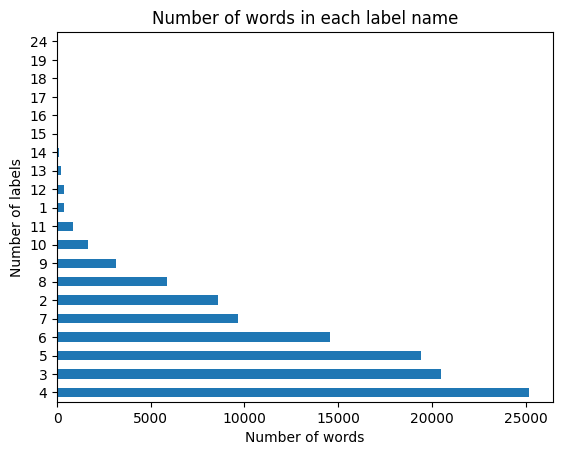

In [14]:
import matplotlib.pyplot as plt

# Get length of words in each label name
label_counts = wikihow_df[ 'label_name' ].str.split().apply( len ).value_counts()

label_counts.plot( kind='barh' )
plt.title( 'Number of words in each label name' )
plt.xlabel( 'Number of words' )
plt.ylabel( 'Number of labels' )
plt.show()

In [15]:
#Split data into train, validation and test sets
shuffled_df = wikihow_df.sample( frac = 1, random_state=42 )

#Split data into train, validation and test sets
n = len( shuffled_df )
train_size = int( TRAIN_SPLIT * n )
val_size   = int( VAL_SPLIT   * n ) + train_size
train, validate, test = np.split( shuffled_df, [ train_size, val_size ])

# If combine, then combine train, val and test into one dataframe
if COMBINE:
    wikihow_df.to_csv( "data.csv" )
else:
    #Save data to csv files
    train.to_csv( "train.csv" ); validate.to_csv( "val.csv" ); test.to_csv( "test.csv" )